### Step 6.  Sentiment Analysis

#### Import submissions and comments from prior steps

In [2]:
import pandas as pd

In [3]:
tfcc_data = pd.read_csv('tfcc_submissions_selected_topics.csv')
tfcc_comments = pd.read_csv('tfcc_comments.csv')


#### Cleanup the comments dataframe by removing the first three characters (this will allow association with the original submission and rename body to selftext)

In [4]:
tfcc_comments = tfcc_comments.rename(columns={'body': 'selftext'})
tfcc_comments['parent_id'] = tfcc_comments['parent_id'].str[3:]

#### Filter comments to only include those which have a parent in the submissions data - this will reduce the total number of comments substantially

In [5]:
# get the number of rows using the shape attribute
start_num_rows = tfcc_comments.shape[0]

# print the number of rows
tfcc_comments = tfcc_comments[tfcc_comments['parent_id'].isin(tfcc_data['id'])]
end_num_rows = tfcc_comments.shape[0]

print("Total rows in comments reduced from " + str(start_num_rows) + " to " + str(end_num_rows))


Total rows in comments reduced from 76848 to 11882


#### Check the sentiment of each row in the submissions dataframe.  Break up the submissions if they are > 512 tokens and then combine the results into a single sentiment score.  Finally, update each row with the sentiment values.  

In [6]:
from transformers import pipeline, DistilBertTokenizerFast
import numpy as np
import torch
from tqdm import tqdm

import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")


sentiment_classifier = pipeline(
    model="distilbert-base-uncased-finetuned-sst-2-english",
    task="sentiment-analysis",
    top_k=None,
    device=0 if torch.cuda.is_available() else -1,  # Set device to GPU if available, otherwise use CPU
)


tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

def get_sentiment(row):
    text = row['selftext']
    chunk_size = 512  # number of tokens per chunk
    token_chunks = []
    for i in range(0, len(text), chunk_size):
        chunk = text[i:i+chunk_size]
        tokens = tokenizer.encode_plus(
            chunk,
            add_special_tokens=True,
            truncation=True,
            padding='max_length',
            max_length=chunk_size,
            return_tensors='pt'
        )
        token_chunks.append(tokens)

    # Analyze sentiment for each chunk
    pos_scores = []
    neg_scores = []
    
    batch_size = 8
    num_batches = len(token_chunks) // batch_size + int(len(token_chunks) % batch_size > 0)

    for batch_idx in tqdm(range(num_batches), desc=f"Processing row {row.name}"):
        batch_start = batch_idx * batch_size
        batch_end = (batch_idx + 1) * batch_size
        batch = token_chunks[batch_start:batch_end]

        input_ids = torch.cat([tokens['input_ids'] for tokens in batch], dim=0).to(device)
        attention_mask = torch.cat([tokens['attention_mask'] for tokens in batch], dim=0).to(device)

        #input_ids = torch.cat([tokens['input_ids'] for tokens in batch], dim=0)
        #attention_mask = torch.cat([tokens['attention_mask'] for tokens in batch], dim=0)

        try:
            with torch.no_grad():
                response = sentiment_classifier.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )
            logits = response.logits
            scores = torch.softmax(logits, dim=-1).tolist()
            pos_scores.extend([score[1] for score in scores])
            neg_scores.extend([score[0] for score in scores])
        except Exception as e:
            print(f"Error occurred in row {row.name}: {e}")
            row['pos_sentiment'] = np.nan
            row['neg_sentiment'] = np.nan
            return row

    # Average the sentiment scores
    avg_pos_sentiment = sum(pos_scores) / len(pos_scores)
    avg_neg_sentiment = sum(neg_scores) / len(neg_scores)
    row['pos_sentiment'] = avg_pos_sentiment
    row['neg_sentiment'] = avg_neg_sentiment

    return row


Using GPU


In [ ]:
tfcc_data = tfcc_data.apply(get_sentiment, axis=1)


#### Print the first few rows to confirm the sentiment values have been added

In [8]:
tfcc_data.head()

,id,title,selftext,author,score,num_comments,created_date,selftext_length,topic,pos_sentiment,neg_sentiment
0,yamv8,"""how fast does your modems go ?",starting off the awesome subreddit\n\ni used t...,[deleted],34,4,2012-08-16 01:24:57,200,0,0.004379,0.995621
1,yicc4,Dishwasher blues,the stories i've heard amazes me but this one ...,[deleted],31,15,2012-08-20 05:05:34,431,0,0.000587,0.999413
2,ymjc0,"Tech support agent, and yet I can't touch my c...",at my work we are not allowed to adjust the mo...,hanzors,40,19,2012-08-22 06:27:29,104,0,0.002825,0.997175
3,yp5ab,Old guy likes to call cable company call cente...,i worked in the call center for a cable compan...,BananaVisit,48,9,2012-08-23 15:04:54,223,0,0.006455,0.993545
4,zgoxq,Hurricanes,i was working at an online christian bookstore...,Ashleyrah,39,2,2012-09-06 19:11:23,154,4,0.001142,0.998858


#### Export the results to a CSV

In [9]:
tfcc_data.to_csv('tfcc_submissions_with_sentiment.csv', index=False)


#### Perform sentiment analysis on comments

In [ ]:
tfcc_comments = tfcc_comments.apply(get_sentiment, axis=1)
tfcc_comments

#### Update comments dataframe sentiment column names

In [11]:
tfcc_comments = tfcc_comments.rename(columns={'pos_sentiment': 'comments_pos_sentiment'})
tfcc_comments = tfcc_comments.rename(columns={'neg_sentiment': 'comments_neg_sentiment'})
tfcc_comments

,parent_id,selftext,score,comments_pos_sentiment,comments_neg_sentiment
3,ymjc0,"this makes me like my call center, everything ...",3.0,0.997643,0.002357
10,yicc4,I would like to find out who's idea it was to ...,6.0,0.001093,0.998907
18,yicc4,&gt;Verify bullshit\n\nWell actually would you...,1.0,0.021951,0.978049
22,ymjc0,we get this at work. our computers are in kios...,2.0,0.001411,0.998589
27,10hg9t,Look for better paying work. Either you get a ...,1.0,0.517005,0.482995
...,...,...,...,...,...
76821,zz8ztg,I posted it elsewhere but I'll say it again:\n...,6.0,0.000496,0.999504
76825,zz7684,Yup. The pay is good but good *God* have I los...,2.0,0.001227,0.998773
76828,zz7684,Different people vibe with different things. I...,2.0,0.012732,0.987268
76839,zz8ztg,I've told the story on here before so I'll jus...,3.0,0.000564,0.999436


#### Export the comments dataframe to a CSV

In [12]:
tfcc_comments.to_csv('tfcc_comments_with_sentiment.csv', index=False)


#### Add a column to the submissions dataframe that shows the average sentiment of comments.  If value is NaN that means the comment was deleted in a prior step because it was too short.

In [13]:
# Calculate the average sentiment for each parent_id in tfcc_comments
sentiment_means = tfcc_comments.groupby('parent_id')[['comments_pos_sentiment', 'comments_neg_sentiment']].mean()


In [14]:
tfcc_data = pd.merge(tfcc_data, sentiment_means, how='left', left_on='id', right_on='parent_id')


In [15]:
tfcc_data

,id,title,selftext,author,score,num_comments,created_date,selftext_length,topic,pos_sentiment,neg_sentiment,comments_pos_sentiment,comments_neg_sentiment
0,yamv8,"""how fast does your modems go ?",starting off the awesome subreddit\n\ni used t...,[deleted],34,4,2012-08-16 01:24:57,200,0,0.004379,0.995621,NaN,NaN
1,yicc4,Dishwasher blues,the stories i've heard amazes me but this one ...,[deleted],31,15,2012-08-20 05:05:34,431,0,0.000587,0.999413,0.011522,0.988478
2,ymjc0,"Tech support agent, and yet I can't touch my c...",at my work we are not allowed to adjust the mo...,hanzors,40,19,2012-08-22 06:27:29,104,0,0.002825,0.997175,0.499527,0.500473
3,yp5ab,Old guy likes to call cable company call cente...,i worked in the call center for a cable compan...,BananaVisit,48,9,2012-08-23 15:04:54,223,0,0.006455,0.993545,NaN,NaN
4,zgoxq,Hurricanes,i was working at an online christian bookstore...,Ashleyrah,39,2,2012-09-06 19:11:23,154,4,0.001142,0.998858,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4732,zwnowo,Why is it so difficult to figure out for custo...,i work for a utility company. i had a call ea...,gameofthrones_addict,57,16,2022-12-27 19:25:20,255,5,0.088222,0.911778,0.002285,0.997715
4733,zwohz7,Something I've been thinking about...,does anyone else think that if these call cent...,ghostof_lisasbabytoe,22,12,2022-12-27 19:58:39,225,3,0.337609,0.662391,0.007117,0.992883
4734,zxn7bt,Call Totals Giving me Anxiety,does anyone else have to make a certain amount...,BatBitch1016,45,7,2022-12-28 22:31:50,165,3,0.004394,0.995606,0.006136,0.993864
4735,zz7684,"kudos to you guys, I don't know how you do it.","i worked in retail for 7 years, recently took ...",Fact0ry0fSadness,211,54,2022-12-30 18:07:48,198,3,0.519592,0.480408,0.256493,0.743507


#### Export the updated dataframe to CSV

In [16]:
tfcc_data.to_csv('tfcc_submissions_with_sentiment_including_comment_sentiment.csv', index=False)


#### Retrieve the topics rollup created in prior steps

In [17]:
tfcc_topics = pd.read_csv('tfcc_submissions_topic_counts.csv')


In [18]:
tfcc_topics
tfcc_topics = tfcc_topics.loc[(tfcc_topics['Topic'] != -1) & (tfcc_topics['Topic'] <= 19)]


In [19]:
tfcc_topics

,Topic,Count,Name
1,0,1048,0_tech_cable_internet_support
2,1,893,1_card_bank_payment_name
3,2,655,2_insurance_clinic_need_car
4,3,544,3_job_feel_working_training
5,4,268,4_delivery_store_orders_package
6,5,244,5_bill_meter_payments_due
7,6,144,6_tow_roadside_truck_assistance
8,7,143,7_people_like_say_voice
9,8,102,8_guest_reservations_hotels_booking
10,9,99,9_spanish_accent_language_speaking


#### Update the topics rollup to include overall sentiment of the posts and comments associated with each topic

In [20]:
# Group tfcc_data by topic and calculate the mean sentiment scores and comment averages
sentiment_by_topic = tfcc_data.groupby('topic').agg({'pos_sentiment': 'mean', 'neg_sentiment': 'mean', 'comments_pos_sentiment': 'mean', 'comments_neg_sentiment': 'mean'})

# Rename the columns for clarity
sentiment_by_topic = sentiment_by_topic.rename(columns={'pos_sentiment': 'avg_pos_sentiment', 'neg_sentiment': 'avg_neg_sentiment', 'comments_pos_sentiment': 'avg_comments_pos_sentiment', 'comments_neg_sentiment': 'avg_comments_neg_sentiment'})

# Merge the average sentiment scores and comment averages into tfcc_topics by matching on the topic column
tfcc_topics = tfcc_topics.merge(sentiment_by_topic, left_on='Topic', right_index=True)





In [21]:
tfcc_topics.head(20)

,Topic,Count,Name,avg_pos_sentiment,avg_neg_sentiment,avg_comments_pos_sentiment,avg_comments_neg_sentiment
1,0,1048,0_tech_cable_internet_support,0.111232,0.888768,0.141026,0.858974
2,1,893,1_card_bank_payment_name,0.116041,0.883959,0.151028,0.848972
3,2,655,2_insurance_clinic_need_car,0.120864,0.879136,0.137366,0.862634
4,3,544,3_job_feel_working_training,0.242732,0.757268,0.310752,0.689248
5,4,268,4_delivery_store_orders_package,0.109191,0.890809,0.146451,0.853549
6,5,244,5_bill_meter_payments_due,0.098576,0.901424,0.141516,0.858484
7,6,144,6_tow_roadside_truck_assistance,0.146956,0.853044,0.126958,0.873042
8,7,143,7_people_like_say_voice,0.171186,0.828814,0.222541,0.777459
9,8,102,8_guest_reservations_hotels_booking,0.147900,0.852100,0.122999,0.877001
10,9,99,9_spanish_accent_language_speaking,0.180457,0.819543,0.199808,0.800192


#### Create a bar chart that shows the relationship between submission and comments sentiment by topic

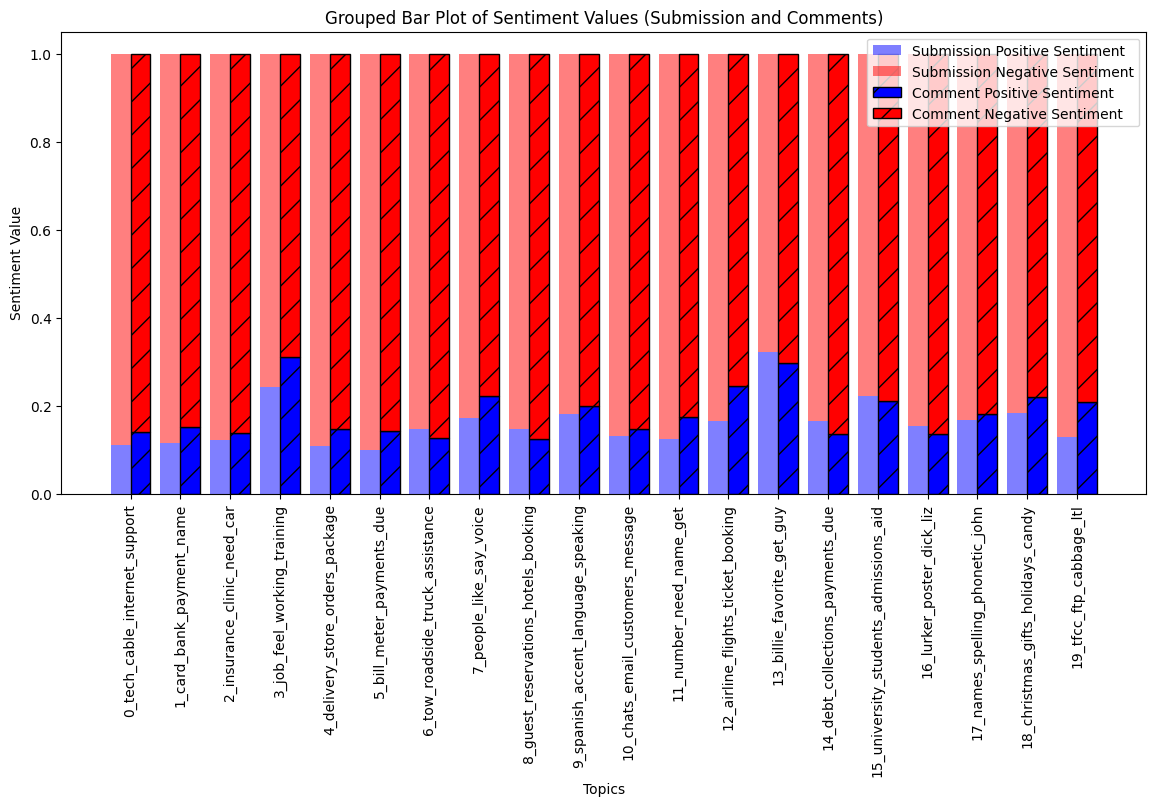

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = tfcc_topics

# Grouped bar plot
n_topics = len(data)
index = np.arange(n_topics)
bar_width = 0.4

plt.figure(figsize=(14, 6))

# Submission sentiments
plt.bar(index, data['avg_pos_sentiment'], bar_width, label='Submission Positive Sentiment', color='blue', alpha=0.5)
plt.bar(index, data['avg_neg_sentiment'], bar_width, label='Submission Negative Sentiment', color='red', alpha=0.5, bottom=data['avg_pos_sentiment'])

# Comment sentiments
plt.bar(index + bar_width, data['avg_comments_pos_sentiment'], bar_width, label='Comment Positive Sentiment', color='blue', hatch='/', edgecolor='black')
plt.bar(index + bar_width, data['avg_comments_neg_sentiment'], bar_width, label='Comment Negative Sentiment', color='red', hatch='/', edgecolor='black', bottom=data['avg_comments_pos_sentiment'])

plt.xticks(index + bar_width / 2, data['Name'], rotation=90)
plt.ylabel('Sentiment Value')
plt.xlabel('Topics')
plt.legend()
plt.title('Grouped Bar Plot of Sentiment Values (Submission and Comments)')
plt.show()

In [23]:
tfcc_topics.to_csv('tfcc_topics_with_sentiment_and_comments_sentiment.csv', index=False)
